### Imports & function definitions

In [1]:
from once_for_all.evaluation.perf_dataset import PerformanceDataset
from utils.config_utils import get_mfcc_params, get_mel_spectrogram_params
import pandas as pd
import numpy as np

import json
import os

import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
def round_to_base(num, base):
    return base * round(num / base)

def create_stats_df(data):
    # Gather initial rows
    df = None
    for k, v in data.items():
        if df is None:
            df = pd.json_normalize(v)
            df = pd.concat([pd.json_normalize(json.loads(k)), df], axis=1)
        else:
            row = pd.json_normalize(v)
            row = pd.concat([pd.json_normalize(json.loads(k)), row], axis=1)
            df = df.append(row)
    
    ks_mean = np.mean(df['ks'].tolist(), axis=1)
    df['ks_mean'] = ks_mean

    e_mean = np.mean(df['e'].tolist(), axis=1)
    df['e_mean'] = e_mean

    d_mean = np.mean(df['d'].tolist(), axis=1)
    df['d_mean'] = d_mean

    df['gpu4lat']= df['net_info.gpu4 latency.hist.sample'].apply(lambda x: x[0][0]/x[0][1])
    df['cpulat']= df['net_info.cpu latency.hist.sample'].apply(lambda x: x[0][0]/x[0][1])

    df['acc_params_ratio'] = df['top1'] / df['net_info.params']
    df['acc_flops_ratio'] = df['top1'] / df['net_info.flops']
    df['acc_gpu4lat_ratio'] = df['top1'] / df['gpu4lat']
    df['acc_cpulat_ratio'] = df['top1'] / df['cpulat']
    
    df = df.drop(columns=['net_info.gpu4 latency.val', 'net_info.gpu4 latency.hist.warmup',
                          'net_info.gpu4 latency.hist.sample',
                          'net_info.cpu latency.val', 'net_info.cpu latency.hist.warmup',
                          'net_info.cpu latency.hist.sample'])
    
    # Round up values for plotting
    base_params = .5
    
    df['ks_m'] = df['ks_mean'].apply(lambda x: round_to_base(num=x,base=base_params))
    df['d_m'] = df['d_mean'].apply(lambda x: round_to_base(num=x,base=base_params))
    df['e_m'] = df['e_mean'].apply(lambda x: round_to_base(num=x,base=base_params))
    df['p'] = df['net_info.params'].apply(lambda x: round_to_base(num=x,base=100))
    
    df['data_shape'] = df['data_shape'].apply(lambda x: str(x))

    return df

#### Define ft_extr_type and params_ids to analyse

In [19]:
ft_extr_types = ["mfcc", "mel_spectrogram", "spectrogram", "linear_stft", "raw"]
ft_extr_type = "mfcc"

params_ids = [1,2,3,4,8]
# params_id = 1

#### Gather data

In [20]:
df = None
full_ft_extr_params_list = None
for p_i, params_id in enumerate(params_ids):
    if ft_extr_type == "mfcc":
        n_mfcc_bins, ft_extr_params_list = get_mfcc_params(params_id)
    elif ft_extr_type == "mel_spectrogram":
        ft_extr_params_list = get_mel_spectrogram_params(params_id)

    for i, ft_e_p in enumerate(ft_extr_params_list):
        if full_ft_extr_params_list is None:
            full_ft_extr_params_list = [list(ft_e_p)]   
        else:     
            if ft_e_p not in full_ft_extr_params_list:
                full_ft_extr_params_list.append(list(ft_e_p))
    
    path = "eval/" + ft_extr_type + str(params_id) + "/"
    performance_dataset = PerformanceDataset(path, use_csv=False)

    for ft_extr_params in ft_extr_params_list:
        data = performance_dataset.load_dataset(ft_extr_params)
        df_ft_extr_p = create_stats_df(data)
        df_ft_extr_p.loc[:, 'params_id'] = params_id
        if df is None:
            df = df_ft_extr_p
        else:
            df = pd.concat([df, df_ft_extr_p], axis=0)
            
print("full ft extr params list : ", full_ft_extr_params_list) 
full_shape_list = list(df['data_shape'].unique())
print("full shape list : ", full_shape_list) 


# Convert ft_extr_params to id for plotting
df = df.loc[:,~df.columns.duplicated()] # Remove duplicates
df["ft_extr_id"] = df["ft_extr_params"].apply(lambda x: full_ft_extr_params_list.index(x))
df["shape_id"] = df['data_shape'].apply(lambda x: full_shape_list.index(x))

df

full ft extr params list :  [[40, 40], [10, 30], [10, 40], [10, 50], [40, 30], [40, 40], [40, 50], [80, 30], [80, 40], [80, 50], [40, 40]]
full shape list :  ['[1, 51, 10]', '[1, 67, 10]', '[1, 41, 10]', '[1, 51, 40]']


w                                                ks  \
0   [0, 0, 0, 0, 0]  [3, 3, 3, 3, 3, 3, 3, 3, 7, 7, 3, 3, 3, 3, 7, 5]   
0   [0, 0, 0, 0, 0]  [3, 3, 3, 3, 3, 3, 3, 5, 7, 5, 7, 7, 5, 3, 5, 7]   
0   [0, 0, 0, 0, 0]  [3, 3, 3, 3, 3, 3, 3, 7, 5, 5, 5, 7, 5, 3, 5, 3]   
0   [0, 0, 0, 0, 0]  [3, 3, 3, 3, 3, 3, 5, 3, 3, 3, 7, 3, 5, 5, 3, 3]   
0   [0, 0, 0, 0, 0]  [3, 3, 3, 3, 3, 3, 5, 3, 5, 5, 5, 7, 3, 5, 3, 5]   
..              ...                                               ...   
0   [0, 0, 0, 0, 0]  [7, 7, 7, 7, 5, 5, 7, 3, 5, 3, 3, 3, 3, 3, 3, 3]   
0   [0, 0, 0, 0, 0]  [7, 7, 7, 7, 5, 5, 7, 7, 5, 5, 3, 5, 3, 5, 7, 5]   
0   [0, 0, 0, 0, 0]  [7, 7, 7, 7, 7, 3, 3, 5, 7, 7, 3, 7, 5, 5, 5, 5]   
0   [0, 0, 0, 0, 0]  [7, 7, 7, 7, 7, 5, 7, 5, 7, 5, 5, 3, 3, 5, 5, 5]   
0   [0, 0, 0, 0, 0]  [7, 7, 7, 7, 7, 7, 7, 3, 7, 7, 3, 3, 5, 3, 7, 3]   

               d                                                 e  \
0   [3, 4, 1, 4]  [1, 3, 3, 1, 2, 3, 3, 2, 1, 1, 2, 1, 3, 2, 1, 3]   
0   [1, 3, 2, 3]  [2, 1, 1, 2, 1, 2, 3, 1, 1, 3, 3, 1, 3, 2, 1, 1]   
0   [4, 1, 2, 1]  [1, 1, 2, 2, 3, 1, 2, 3, 1, 2, 3, 3, 3, 3, 1, 2]   
0   [3, 2, 2, 4]  [3, 3, 2, 2, 2, 3, 3, 3, 1, 2, 3, 2, 3, 2, 1, 1]   
0   [3, 1, 2, 4]  [3, 3, 3, 3, 1, 2, 2, 3, 3, 2, 3, 2, 1, 2, 2, 3]   
..           ...                                               ...   
0   [2, 1, 4, 2]  [3, 2, 2, 1, 3, 3, 1, 1, 3, 3, 3, 1, 2, 3, 2, 2]   
0   [2, 4, 2, 1]  [3, 2, 2, 3, 1, 3, 1, 2, 1, 2, 3, 3, 1, 2, 2, 2]   
0   [3, 3, 4, 4]  [1, 3, 3, 1, 1, 2, 3, 1, 1, 2, 2, 2, 2, 1, 1, 3]   
0   [3, 3, 2, 1]  [1, 1, 1, 2, 1, 1, 1, 3, 2, 1, 1, 2, 3, 2, 3, 1]   
0   [2, 4, 4, 3]  [1, 1, 3, 3, 2, 3, 1, 3, 1, 2, 3, 3, 3, 1, 3, 2]   

   ft_extr_params   data_shape       top1  net_info.params  net_info.flops  \
0        [40, 40]  [1, 51, 10]  89.972775           242572      12158080.0   
0        [40, 40]  [1, 51, 10]  88.770416           162508       5018240.0   
0        [40, 40]  [1, 51, 10]  89.042653           131724       8513216.0   
0        [40, 40]  [1, 51, 10]  89.019966           203276      12241728.0   
0        [40, 40]  [1, 51, 10]  88.611616           212492      11718848.0   
..            ...          ...        ...              ...             ...   
0        [40, 40]  [1, 51, 40]  90.630676           225292      42979584.0   
0        [40, 40]  [1, 51, 40]  91.311252           158156      38839232.0   
0        [40, 40]  [1, 51, 40]  90.313067           266636      49109568.0   
0        [40, 40]  [1, 51, 40]  91.243197           101708      16272320.0   
0        [40, 40]  [1, 51, 40]  90.245012           264972      26426176.0   

    ks_mean  ...  acc_flops_ratio  acc_gpu4lat_ratio  acc_cpulat_ratio  ks_m  \
0     3.875  ...         0.000007          30.219348         11.462609   4.0   
0     4.500  ...         0.000018          34.770560         17.418138   4.5   
0     4.125  ...         0.000010          39.907672         19.076493   4.0   
0     3.625  ...         0.000007          27.941091         12.552928   3.5   
0     4.000  ...         0.000008          27.966535         14.491804   4.0   
..      ...  ...              ...                ...               ...   ...   
0     4.625  ...         0.000002          31.579033          7.931012   4.5   
0     5.625  ...         0.000002          34.028179          9.515729   5.5   
0     5.625  ...         0.000002          22.366187          6.630361   5.5   
0     5.625  ...         0.000006          34.264021          9.529805   5.5   
0     5.625  ...         0.000003          22.806506          8.078951   5.5   

    d_m  e_m       p  params_id  ft_extr_id  shape_id  
0   3.0  2.0  242600          1           0         0  
0   2.0  2.0  162500          1           0         0  
0   2.0  2.0  131700          1           0         0  
0   3.0  2.0  203300          1           0         0  
0   2.5  2.5  212500          1           0         0  
..  ...  ...     ...        ...         ...       ...  
0   2.0  2

### Global plots, overall stats

for each params_id:
divide ft_extr_params (ie 10 bins != 40 bins)

- params / acc
- flops / acc
- ks mean / acc
- depth mean / acc
- expand mean / acc

In [21]:
temp_df = df

print(full_ft_extr_params_list)
print(full_shape_list)
print(df.columns)

[[40, 40], [10, 30], [10, 40], [10, 50], [40, 30], [40, 40], [40, 50], [80, 30], [80, 40], [80, 50], [40, 40]]
['[1, 51, 10]', '[1, 67, 10]', '[1, 41, 10]', '[1, 51, 40]']
Index(['w', 'ks', 'd', 'e', 'ft_extr_params', 'data_shape', 'top1',
       'net_info.params', 'net_info.flops', 'ks_mean', 'e_mean', 'd_mean',
       'gpu4lat', 'cpulat', 'acc_params_ratio', 'acc_flops_ratio',
       'acc_gpu4lat_ratio', 'acc_cpulat_ratio', 'ks_m', 'd_m', 'e_m', 'p',
       'params_id', 'ft_extr_id', 'shape_id'],
      dtype='object')


Filter by ft_extr_params_id or params_id

In [22]:
keep_ft_extr_id_list = [0, 1, 2, 3, 4, 5, 6, 7, 8]

filter_cond = 0
for p in keep_ft_extr_id_list:
    filter_cond = filter_cond | (temp_df["ft_extr_id"] == p)

temp_df = temp_df.loc[filter_cond]

keep_params_id_list = [1,2,3,4,5,7,8]
filter_cond = 0
for p in keep_params_id_list:
    filter_cond = filter_cond | (temp_df["params_id"] == p)

temp_df = temp_df.loc[filter_cond]

In [43]:
flops_base = 1000000
params_base = 10000
ks_base = .25
d_base = .25
e_base = .1
oth_base = .5

In [44]:
def remove_worse_and_plot(_df, x, y, base):
    df = _df.copy()
    x_col = "rnd_" + x
    df[x_col] = df[x].apply(lambda val: round_to_base(num=val, base=base)) # build col with rounded val
    
    col = "shape_id" #"params_id"
    max_df = df.groupby([x_col,col]).max().reset_index() # For all same rounded x values, remove non max y
    
    max_df[max_df['ft_extr_id'] == 3]

    g = sns.FacetGrid(max_df, col=col)
    g.map(sns.regplot, x_col, y, order=2)
    


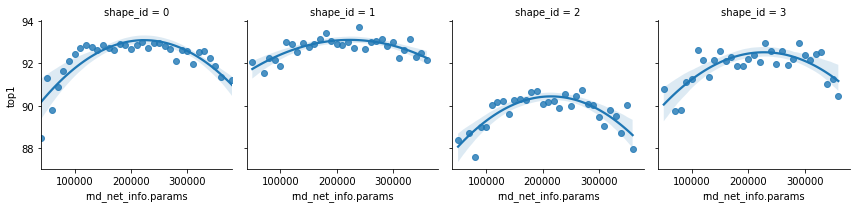

In [37]:
remove_worse_and_plot(df, 'net_info.params', 'top1', base=params_base)

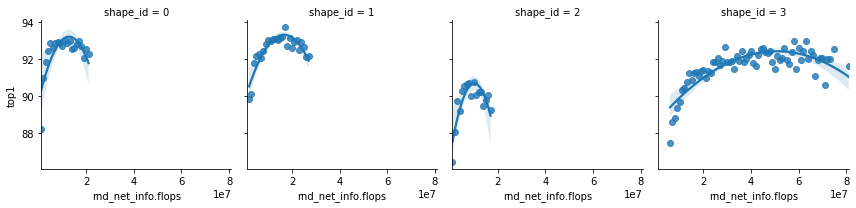

In [38]:
remove_worse_and_plot(df, 'net_info.flops', 'top1', base=flops_base)

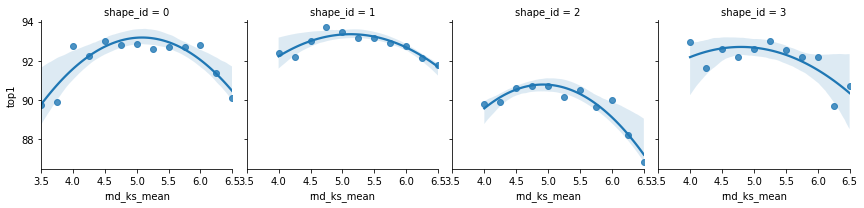

In [39]:
remove_worse_and_plot(df, 'ks_mean', 'top1', base=ks_base)

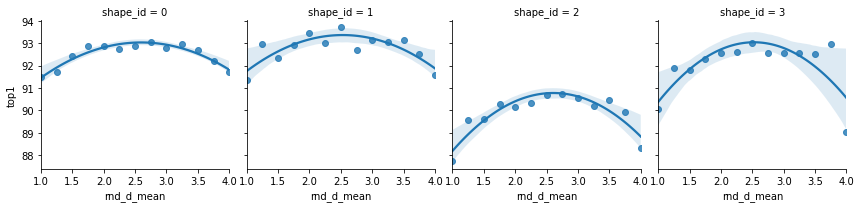

In [45]:
remove_worse_and_plot(df, 'd_mean', 'top1', base=d_base)

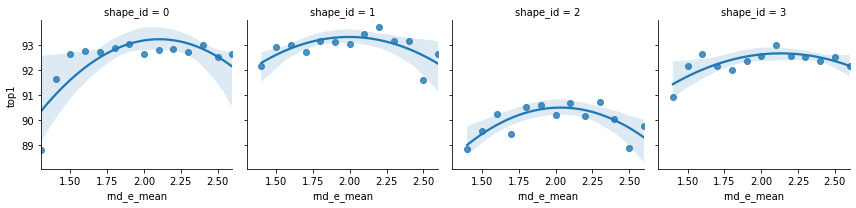

In [46]:
remove_worse_and_plot(df, 'e_mean', 'top1', base=e_base)

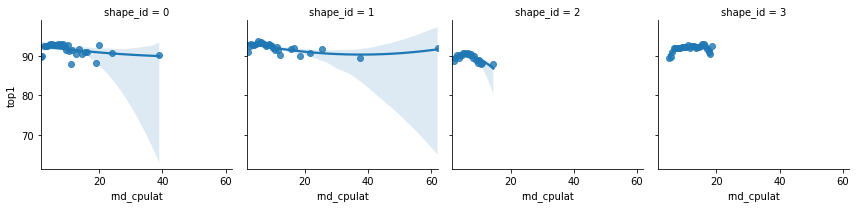

In [47]:
remove_worse_and_plot(df, 'cpulat', 'top1', base=oth_base)

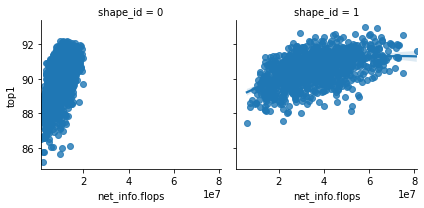

In [18]:
# sns.scatterplot(x="net_info.flops", y="top1", data=df, hue="params_id")
col = "shape_id" #"params_id"

g = sns.FacetGrid(temp_df, col=col)
g.map(sns.regplot, "net_info.flops", "top1", order=2)

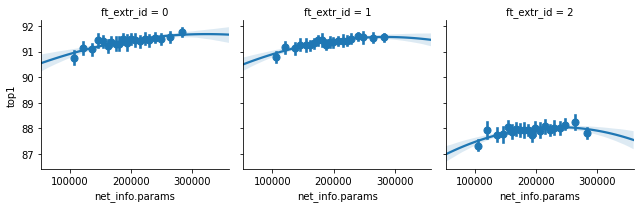

In [123]:
g = sns.FacetGrid(temp_df, col=col)
g.map(sns.regplot, "net_info.params", "top1", x_bins=20, order=2)

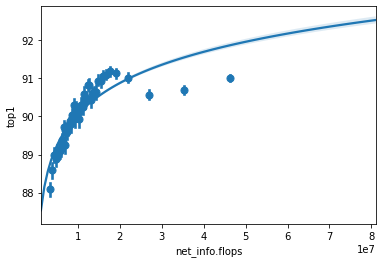

In [86]:
splot = sns.regplot(x="net_info.flops", y="top1", data=temp_df, x_estimator=np.mean, logx=True, x_bins=50) # order =2

<AxesSubplot:xlabel='net_info.params', ylabel='top1'>

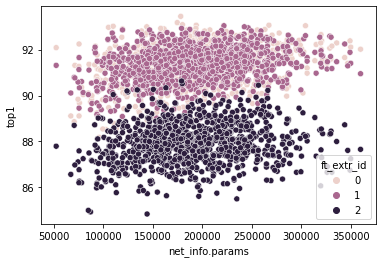

In [109]:
sns.scatterplot(x="net_info.params", y="top1", data=df, hue="ft_extr_id")

[[40, 40], [10, 30], [10, 40], [10, 50], [40, 30], [40, 40], [40, 50], [80, 30], [80, 40], [80, 50], [40, 40]]


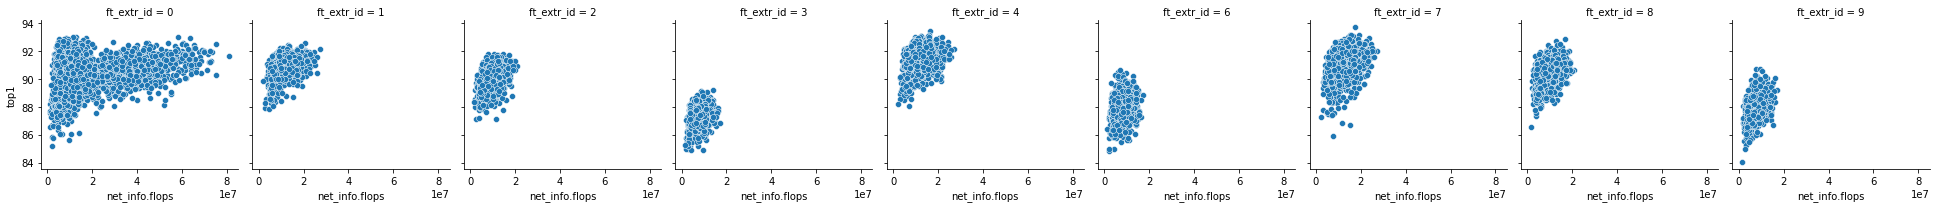

In [88]:
print(full_ft_extr_params_list)
g = sns.FacetGrid(df, col="ft_extr_id")
g.map(sns.scatterplot, "net_info.flops", "top1")

In [89]:
sns.catplot(x="ks_m", y="top1", data=df, kind="box", hue="params_id")

ValueError: Could not interpret input 'ks_m'

<AxesSubplot:xlabel='net_info.params', ylabel='top1'>

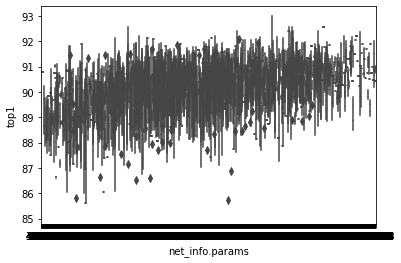

In [58]:
sns.boxplot(x="net_info.params", y="top1", data=df)

In [59]:
sns.boxplot(x="k_mean", y="top1", data=df)

ValueError: Could not interpret input 'k_mean'

<AxesSubplot:xlabel='d_mean', ylabel='top1'>

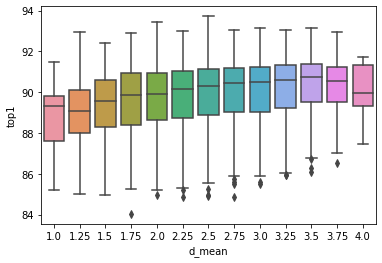

In [7]:
sns.boxplot(x="d_mean", y="top1", hue="params_id", data=df)

<AxesSubplot:xlabel='e_mean', ylabel='top1'>

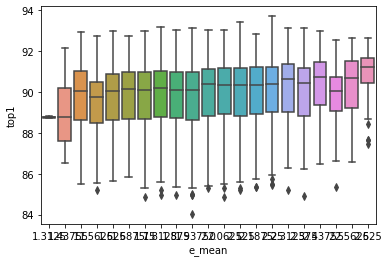

In [8]:
sns.boxplot(x="e_mean", y="top1", data=df)

In [ ]:
g = sns.FacetGrid(df, col="params_id", height=4, aspect=.5)
g.map(sns.boxplot, "n_params", "top1")


In [5]:
df['top1'].describe()

count    6000.000000
mean       86.188371
std         3.214725
min        74.818510
25%        84.227542
50%        86.184215
75%        87.590743
max        93.874773
Name: top1, dtype: float64

In [6]:
df['net_info.params'].describe()

count      6000.000000
mean     192334.304000
std       53057.884802
min       52364.000000
25%      156556.000000
50%      189356.000000
75%      227756.000000
max      359820.000000
Name: net_info.params, dtype: float64

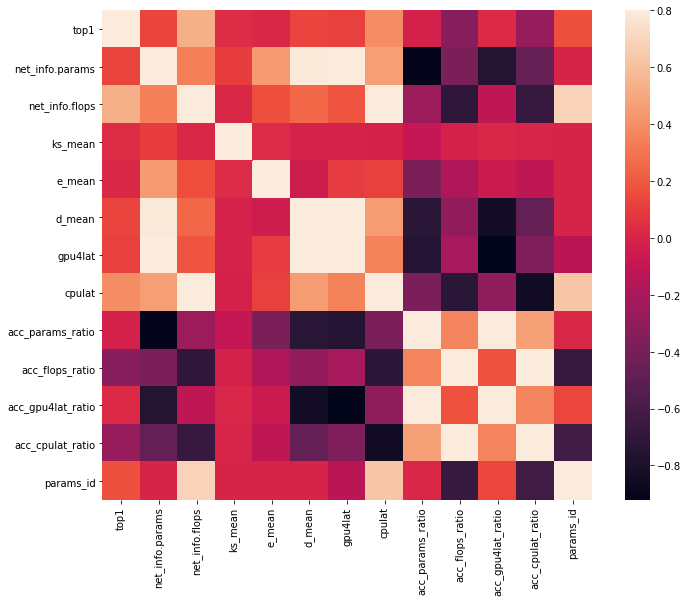

In [7]:
#correlation matrix
corrmat = df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

/Users/nielsescarfail/opt/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:1969: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


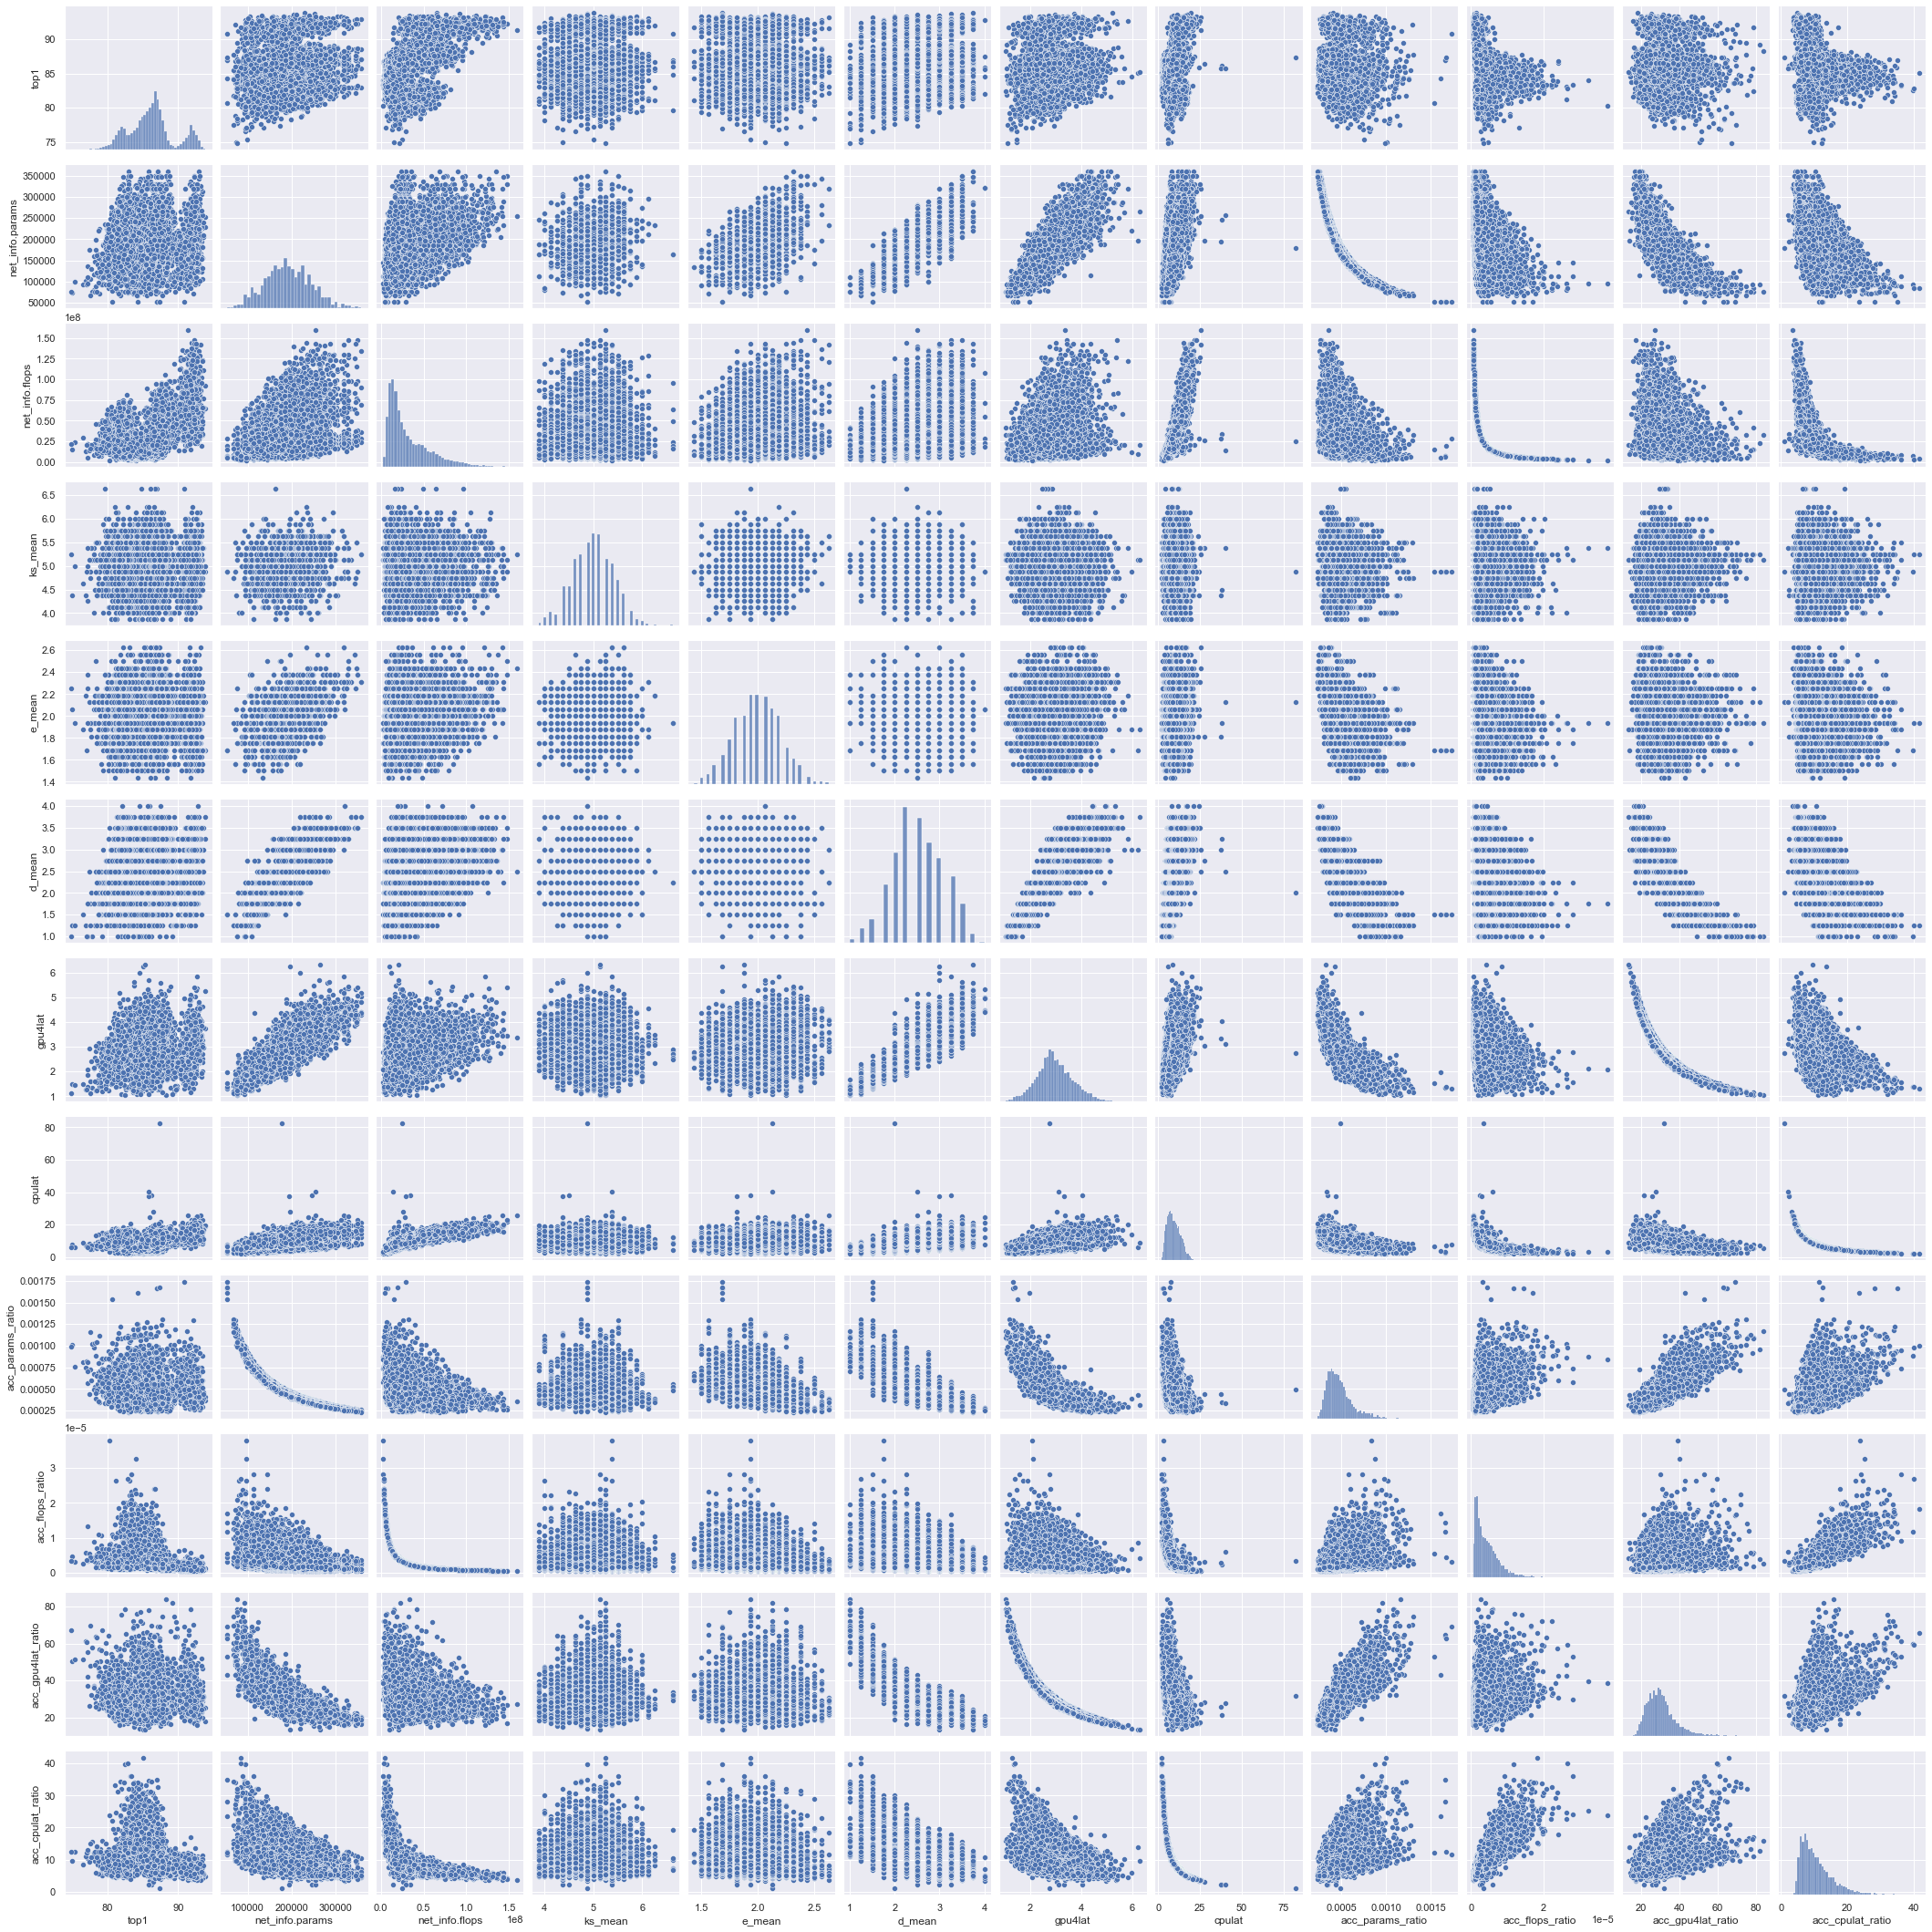

In [8]:
#scatterplot
sns.set()
cols = ['top1', 'net_info.params', 'net_info.flops', 'ks_mean', 'e_mean',
       'd_mean', 'gpu4lat', 'cpulat', 'acc_params_ratio', 'acc_flops_ratio',
       'acc_gpu4lat_ratio', 'acc_cpulat_ratio']
sns.pairplot(df[cols], size = 2.5)
plt.show();

In [9]:
df2 = df
df = df2
df.columns

Index(['w', 'ks', 'd', 'e', 'ft_extr_params', 'ft_extr_params', 'data_shape',
       'top1', 'net_info.params', 'net_info.flops', 'ks_mean', 'e_mean',
       'd_mean', 'gpu4lat', 'cpulat', 'acc_params_ratio', 'acc_flops_ratio',
       'acc_gpu4lat_ratio', 'acc_cpulat_ratio', 'params_id'],
      dtype='object')

In [10]:
df2 = df

In [11]:
def plot_top_n(df, column_name, in_f_of_column, n):
    temp = df.sort_values(in_f_of_column, ascending=False)
    top_n = temp.head(n)
    
    acc = top_n['top1']
    y = 'top1' 
    x = column_name

    sns.set_context("paper")
    # f, ax = plt.subplots(figsize=(7, 7))
    # ax.set(xscale="log", yscale="log")
    splot = sns.regplot(x=x, y=y, data=pd.concat([top_n[column_name], acc], axis=1), order=2, logx=True)
    # splot.set(xscale="log")
    

In [12]:
df['cpulatr'] = df['cpulat'].apply(lambda x: round(x,1))

df_topcpu = df.groupby('cpulatr')['top1'].max()
# df['cpu'] = df.groupby('cpulatr')['top1'].max()
df_topcpu = pd.DataFrame(df_topcpu)
df_topcpu = df_topcpu.reset_index(level=0)
df_topcpu

cpulatr       top1
0        2.0  85.027226
1        2.1  82.849368
2        2.3  83.393831
3        2.4  82.259533
4        2.5  86.955539
..       ...        ...
201     27.8  86.456444
202     37.5  85.775865
203     38.2  86.206901
204     40.1  85.753175
205     82.3  87.318516

[206 rows x 2 columns]

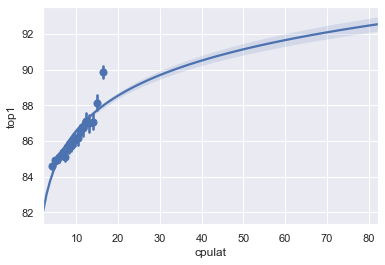

In [16]:
y = 'top1' 
x = 'cpulat'
splot = sns.regplot(x=x, y=y, data=df, logx=True, x_bins=20) # order =2

In [17]:
df_1 = df[df['params_id'] == 1]
df_2 = df[df['params_id'] == 2]

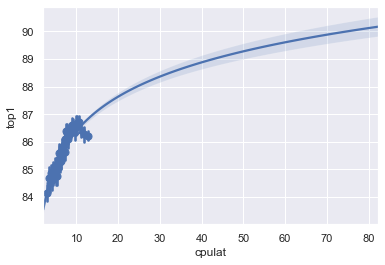

In [18]:
splot = sns.regplot(x=x, y=y, data=df_1, x_estimator=np.mean, logx=True, x_bins=50) # order =2


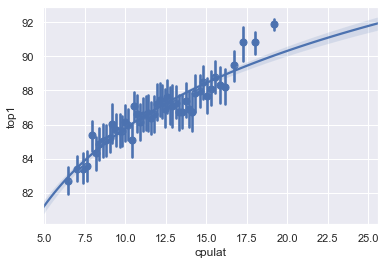

In [19]:
splot = sns.regplot(x=x, y=y, data=df_2, x_estimator=np.mean, logx=True, x_bins=50) # order =2


In [11]:
plot_top_n(df_topcpu, 'cpulatr', 'top1', 1000)

ValueError: Mutually exclusive regression options.

In [ ]:
plot_top_n(df, 'cpulat', 'acc_cpulat_ratio', 100)

In [ ]:
plot_top_n(df, 'params', 'acc_cpulat_ratio', 1000)

In [ ]:
df['top1'].describe()

In [69]:
temp = df2.sort_values("acc_params_ratio", ascending=Fa)
top_n = temp.head(100)
top_n

w                                                ks  \
0   [0, 0, 0, 0, 0]  [3, 5, 5, 3, 5, 7, 3, 3, 3, 7, 7, 3, 3, 7, 3, 3]   
0   [0, 0, 0, 0, 0]  [3, 3, 3, 3, 3, 7, 7, 3, 7, 3, 7, 3, 3, 3, 3, 5]   
0   [0, 0, 0, 0, 0]  [3, 3, 3, 3, 7, 3, 5, 5, 3, 5, 5, 3, 7, 5, 7, 3]   
0   [0, 0, 0, 0, 0]  [3, 5, 5, 5, 5, 7, 5, 7, 5, 5, 7, 7, 3, 3, 7, 3]   
0   [0, 0, 0, 0, 0]  [3, 3, 3, 7, 7, 7, 5, 7, 3, 7, 3, 7, 5, 7, 3, 7]   
..              ...                                               ...   
0   [0, 0, 0, 0, 0]  [3, 7, 3, 3, 3, 3, 5, 7, 7, 7, 3, 5, 5, 5, 5, 7]   
0   [0, 0, 0, 0, 0]  [3, 5, 5, 5, 5, 7, 5, 5, 7, 7, 5, 5, 3, 5, 7, 7]   
0   [0, 0, 0, 0, 0]  [3, 3, 7, 3, 3, 3, 5, 5, 7, 5, 3, 7, 5, 3, 7, 3]   
0   [0, 0, 0, 0, 0]  [3, 7, 5, 3, 3, 5, 5, 3, 7, 3, 7, 7, 3, 5, 5, 3]   
0   [0, 0, 0, 0, 0]  [3, 5, 7, 7, 5, 7, 3, 3, 5, 3, 5, 5, 5, 3, 7, 3]   

               d                                                 e  \
0   [2, 1, 2, 1]  [1, 1, 2, 3, 1, 3, 1, 3, 1, 1, 3, 2, 1, 2, 3, 3]   
0   [1, 1, 1, 1]  [1, 2, 3, 2, 1, 3, 1, 2, 2, 1, 3, 1, 1, 2, 2, 3]   
0   [2, 1, 1, 1]  [1, 1, 2, 3, 2, 1, 2, 1, 1, 1, 2, 2, 1, 1, 3, 3]   
0   [3, 1, 1, 1]  [1, 1, 1, 2, 2, 3, 3, 1, 1, 1, 2, 1, 1, 3, 1, 2]   
0   [4, 1, 1, 2]  [1, 1, 1, 1, 1, 1, 1, 2, 1, 3, 3, 2, 1, 1, 1, 2]   
..           ...                                               ...   
0   [2, 2, 1, 1]  [1, 2, 1, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 3, 1, 2]   
0   [3, 1, 1, 1]  [1, 2, 2, 2, 1, 1, 2, 2, 2, 2, 3, 2, 2, 2, 3, 1]   
0   [4, 1, 1, 1]  [1, 1, 2, 2, 3, 1, 3, 1, 1, 3, 2, 2, 1, 2, 2, 3]   
0   [2, 1, 2, 1]  [2, 3, 1, 3, 1, 3, 3, 1, 2, 1, 1, 1, 1, 1, 2, 2]   
0   [2, 3, 1, 1]  [1, 1, 1, 3, 1, 2, 3, 3, 1, 1, 3, 2, 2, 1, 3, 3]   

   ft_extr_params ft_extr_params   data_shape       top1  net_info.params  \
0        [40, 40]       [40, 40]  [1, 51, 10]  88.498189            36044   
0        [40, 40]       [40, 40]  [1, 51, 10]  87.545373            39948   
0        [40, 40]       [40, 40]  [1, 51, 10]  87.568062            47436   
0        [40, 40]       [40, 40]  [1, 51, 10]  90.131579            49804   
0        [40, 40]       [40, 40]  [1, 51, 10]  87.114340            49996   
..            ...            ...          ...        ...              ...   
0        [40, 40]       [40, 40]  [1, 51, 10]  90.426501            94156   
0        [40, 40]       [40, 40]  [1, 51, 10]  90.766786            94668   
0        [40, 40]       [40, 40]  [1, 51, 10]  89.768601            93836   
0        [40, 40]       [40, 40]  [1, 51, 10]  88.452817            93004   
0        [40, 40]       [40, 40]  [1, 51, 10]  90.313071            95372   

    net_info.flops  ...  net_info.cpu latency.hist.sample ks_mean  e_mean  \
0        1756096.0  ...        [[24.336814880371094, 10]]   4.375  1.9375   
0        1331008.0  ...         [[20.97606658935547, 10]]   4.125  1.8750   
0        2938880.0  ...         [[21.93307876586914, 10]]   4.375  1.6875   
0        3696768.0  ...        [[27.873992919921875, 10]]   5.125  1.6250   
0        3162176.0  ...         [[25.54464340209961, 10]]   5.250  1.4375   
..             ...  ...                               ...     ...     ...   
0        5928192.0  ...         [[35.35008430480957, 10]]   4.875  1.7500   
0        6596160.0  ...         [[39.74556922912598, 10]]   5.375  1.8750   
0        8708544.0  ...         [[37.22548484802246, 10]]   4.500  1.8750   
0        7486656.0  ...        [[31.736373901367188, 10]]   4.625  1.7500   
0        3720192.0  ...         [[30.73859214782715, 10]]   4.750  1.9375   

    d_mean   gpu4lat    cpulat  acc_params_ratio  acc_flops_ratio  \
0     1.50  1.396060  2.433681          0.002455         0.000050   
0     1.00  1.195025  2.097607          0.002191         0.000066   
0     1.25  1.273298  2.193308          0.001846         0.000030   
0     1.50  1.831341  2.787399          0.001810         0.000024   
0     2.00  1.923013  2.554464          0.001742         0.000028   
..     ...       ...       ...      

In [64]:
df2.columns

Index(['w', 'ks', 'd', 'e', 'ft_extr_params', 'ft_extr_params', 'data_shape',
       'top1', 'net_info.params', 'net_info.flops',
       'net_info.gpu4 latency.val', 'net_info.gpu4 latency.hist.warmup',
       'net_info.gpu4 latency.hist.sample', 'net_info.cpu latency.val',
       'net_info.cpu latency.hist.warmup', 'net_info.cpu latency.hist.sample',
       'ks_mean', 'e_mean', 'd_mean', 'gpu4lat', 'cpulat', 'acc_params_ratio',
       'acc_flops_ratio', 'acctgpu4lat', 'acctcpulat'],
      dtype='object')

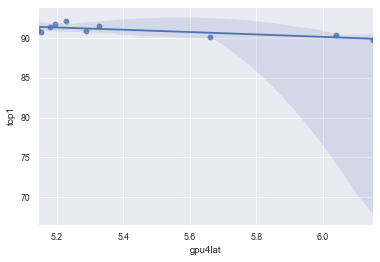

In [68]:
plot_top_n(df2, 'gpu4lat', 'acctgpu4lat', 10)

/Users/nielsescarfail/opt/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:1969: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


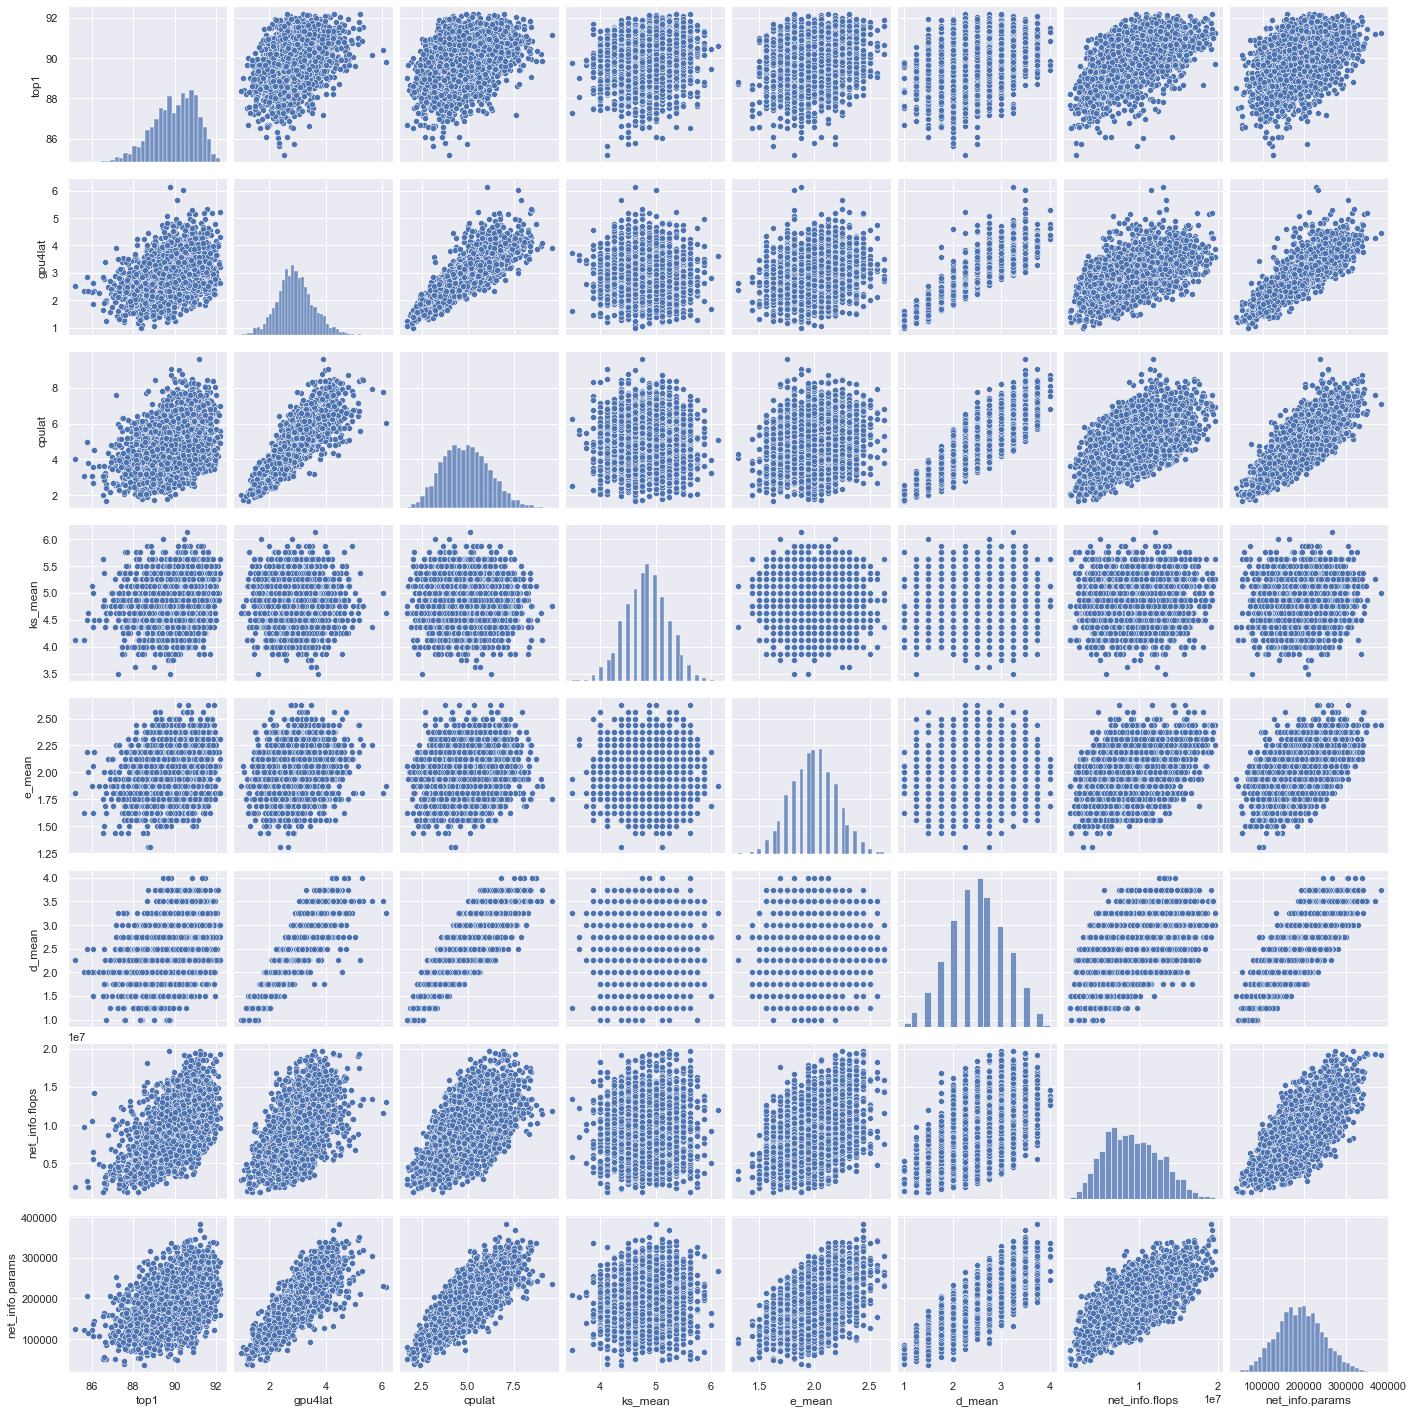

In [55]:
#scatterplot
sns.set()
cols = ['top1', 'gpu4lat', 'cpulat', 'ks_mean', 'e_mean', 'd_mean', 'net_info.flops', 'net_info.params']
sns.pairplot(df[cols], size = 2.5)
plt.show();

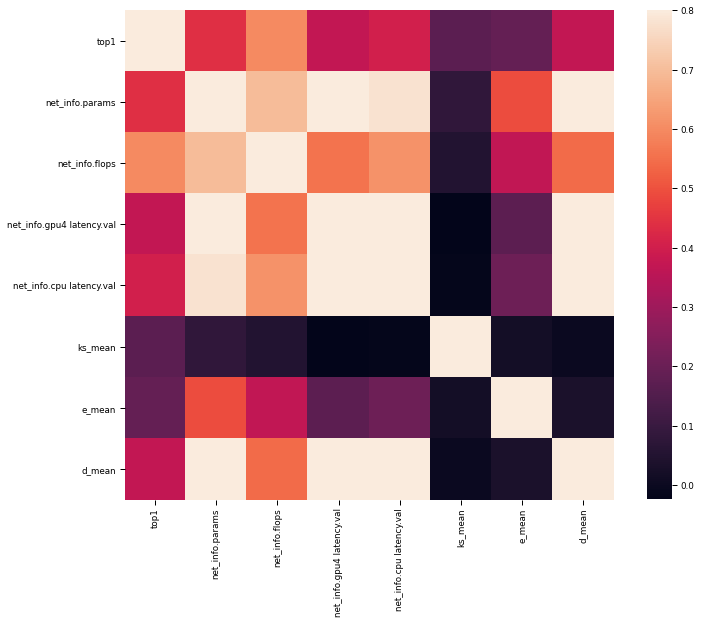

In [75]:
corrmat = df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

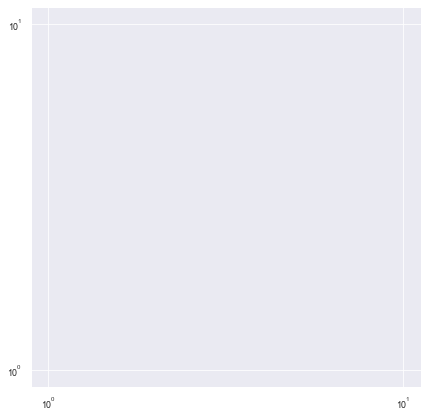

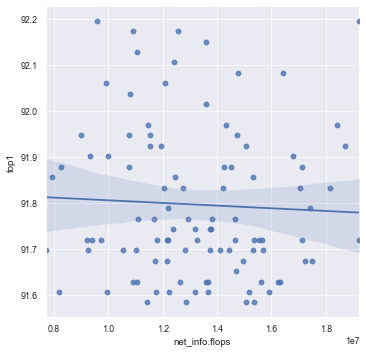

In [85]:
df = top_100
acc = df['top1']
flops = df['net_info.flops'] / 1e6
ks_mean = df['ks_mean']

val_vs_acc = 'net_info.flops' # 'net_info.params'# 'ks_mean' # 'net_info.flops'


y = 'top1' # , 'net_info.flops'
x = val_vs_acc

df_v = df[val_vs_acc]


sns.set_context("paper")
f, ax = plt.subplots(figsize=(7, 7))
ax.set(xscale="log", yscale="log")
sns.lmplot(x=x, y=y, data=pd.concat([df_v, acc], axis=1))


In [74]:
sns.boxplot(x=x, y=y, data=pd.concat([df_v, acc], axis=1), ax=ax)

/Users/nielsescarfail/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:373: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_xlim(-.5, len(self.plot_data) - .5, auto=None)


<AxesSubplot:xlabel='d_mean', ylabel='top1'>

In [30]:
# new df from the column of lists
split_df = pd.DataFrame(df['ks'].tolist())
# display the resulting df
split_df

0   1   2   3   4   5   6   7   8   9   10  11  12  13  14  15
0      3   3   3   3   3   3   3   3   7   7   3   3   3   3   7   5
1      3   3   3   3   3   3   3   5   7   5   7   7   5   3   5   7
2      3   3   3   3   3   3   3   7   5   5   5   7   5   3   5   3
3      3   3   3   3   3   3   5   3   3   3   7   3   5   5   3   3
4      3   3   3   3   3   3   5   3   5   5   5   7   3   5   3   5
...   ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..
1375   3   5   3   7   5   3   3   3   7   7   7   3   3   7   3   7
1376   3   5   3   7   5   3   3   5   3   3   3   7   3   5   3   7
1377   3   5   3   7   5   3   3   5   3   7   5   5   3   7   7   7
1378   3   5   3   7   5   3   3   5   5   3   5   3   3   7   7   3
1379   3   5   3   7   5   3   3   5   7   5   7   3   3   3   3   7

[1380 rows x 16 columns]

In [19]:
df['top1'].mean()

89.81433759674431